## Equations of Linear Elasticity

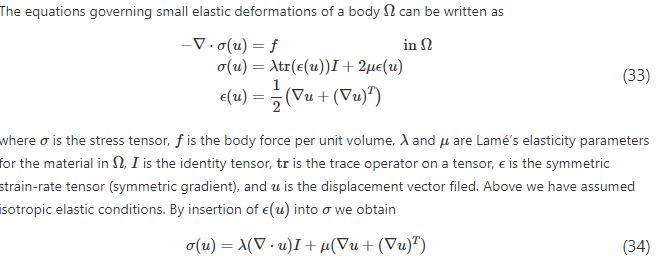
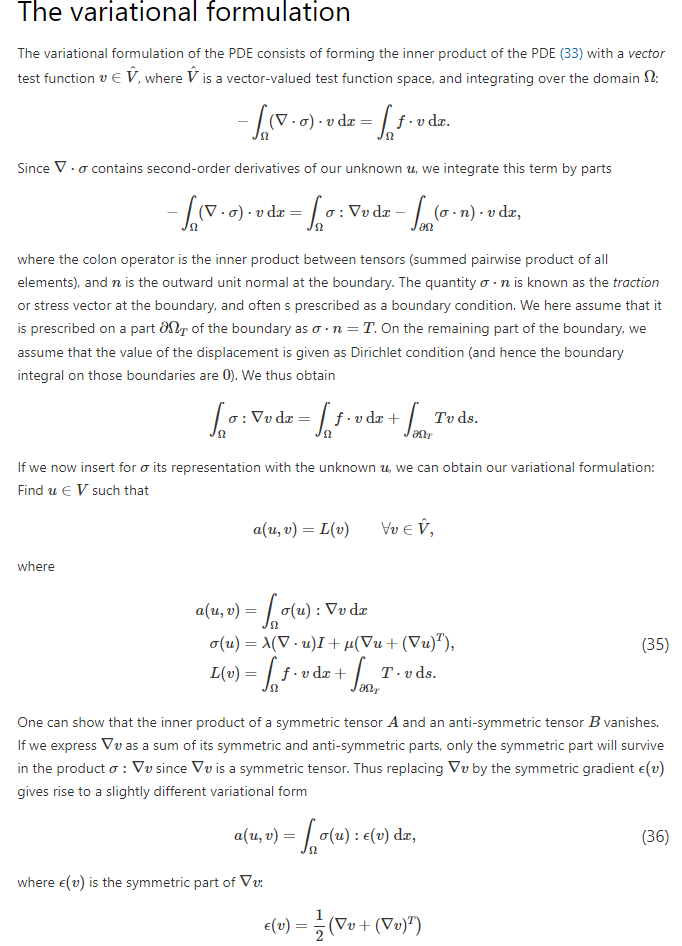

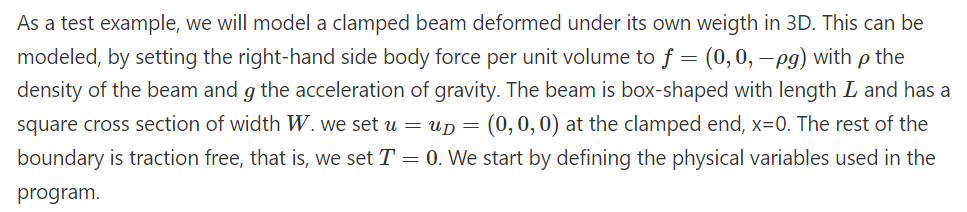

In [6]:
# Scaled variable
L = 1
W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [7]:
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx import mesh, fem, plot, io

domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])],
                  [20,6,6], cell_type=mesh.CellType.hexahedron)
V = fem.VectorFunctionSpace(domain, ("CG", 1))

In [8]:
# Boundary Conditions
# clamp the boundary at x=0 by using a marker function,
# which locate the facets where x is close to zero by machine prescision

def clamped_boundary(x):
    return np.isclose(x[0], 0)

fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0,0,0], dtype=ScalarType)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

T = fem.Constant(domain, ScalarType((0, 0, 0)))
ds = ufl.Measure("ds", domain=domain)

def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType((0, 0, -rho*g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

problem = fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   pyvista.start_xvfb()
   figure_as_array = p.screenshot("deflection.png")

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

In [9]:
with io.XDMFFile(domain.comm, "deformation.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    uh.name = "Deformation"
    xdmf.write_function(uh)
    